# **Analysis of Boston crime reports**

We are about to embark on a journey to explore the crime reports recorded in Boston. 

In particular, we answer the following questions:
1. What types of crimes are most common? 
2. How are they related to Location and Time?
3. Which are the dangerous and safe areas in Boston?

In [ ]:
# Let's import some essentials
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

Now let's read in the data.

In [ ]:
df = pd.read_csv("../input/crimes-in-boston/crime.csv",encoding='latin-1')
df.head(5)

## ** Understanding the variables **

*** This data was obtained from [this](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system/resource/9c30453a-fefa-4fe0-b51a-5fc09b0f4655?view_id=380adcd5-c841-4320-a9fa-604e7a6a94f5) link. ***
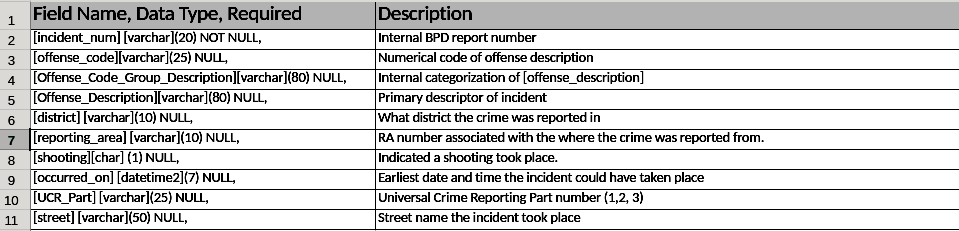


So I have identified three categories of variables here. 
1. *Location* variables like DISTRICT, REPORTING_AREA, STREET, Lat, Long, Location 
2. *Nature* of the crime like OFFENSE_CODE, OFFENSE_CODE_GROUP, OFFENSE_DESCRIPTION, UCR_PART
3. *Time* variables like OCCURED_ON_DATE, YEAR, MONTH, DAY_OF_WEEK, HOUR

Intuitively, 1. and 2. will influence the kind as well as frequency of crimes.

### ** Removing less useful variables**

By observing the variables, it can be easily deduced that the Location variable is just storing the concatenation of the Lat and Long, so let's get rid of this.

In [ ]:
df = df.drop("Location", axis = 1)

Next we have variables like INCIDENT_NUMBER and OFFENSE_CODE, which serve no purpose in answering our questions. So, let's get rid of them too.

In [ ]:
df = df.drop(["INCIDENT_NUMBER", "OFFENSE_CODE"], axis = 1)
df.head(5)

### **Missing Values **

The column SHOOTING appears to have nothing but NaN values. Let's confirm that.

In [ ]:
df['SHOOTING'].describe()

In [ ]:
df["SHOOTING"].isna().sum()

Most of the entries are NaNs, but there are a few 'Y's in there too. But according to the descriptions of the variables in the table given above, NaN corresponds to "no shooting" incident. So let's change NaN to 'N'.

In [ ]:
df["SHOOTING"].fillna('N', inplace=True)
df.head(5)

In [ ]:
df.OFFENSE_CODE_GROUP.isna().sum()

NaNs may also occur in other variables. So, let's check that.

*** Examining the YEAR variable ***

In [ ]:
years = [2015, 2016, 2017, 2018]
for year in years:
    print(df[df["YEAR"] == year]["MONTH"].unique())

* Complete data is available for the years 2016 and 2017.
* 2015 : data available from June onwards, 2018: data available till September.

Other *** Time *** variables: HOUR, DAY_OF_WEEK, MONTH, OCCURRED_ON_DATE

In [ ]:
time_list = ["HOUR", "DAY_OF_WEEK", "MONTH", "OCCURRED_ON_DATE"]
for item in time_list:
    print("No. of NaNs in {} = {}".format(item, df[item].isna().sum()))

*** Location *** variables: DISTRICT, REPORTING_AREA, STREET, Lat, Long, Location

In [ ]:
locations_list = ["DISTRICT", "REPORTING_AREA", "STREET", "Lat", "Long"]
for item in locations_list:
    print("No. of NaNs in {} = {}".format(item, df[item].isna().sum()))

DISTRICT and STREET have missing values. REPORTING_AREA looks like a good variable to consider, since it has no missing values. But, let's also have a look at Lat and Long.

In [ ]:
df["Long"].describe()

Lat is assigned to -1 to indicate an absence. Similarly, for Long, -1 indicates absence. Let's replace -1 with None.

In [ ]:
df["Lat"].replace(-1, None, inplace=True)
df["Long"].replace(-1, None, inplace=True)
(df["Long"].isna()).sum()

### ** Univariate Analysis **

*** Visualizations ***

We can start with plotting the histogram of a variable like "OFFENSE_CODE". The plot will not be too clear because we have 67 types of offenses in total. Let's just take the top 10 most frequent and plot their histogram.

In [ ]:
def plot_quantitative(df, col1=None, col2=None, hue=None, k=10, palette=None):
    if col2 == None:
        col2 = col1
    sns.catplot(x=col1, y=col2, kind='count', height=8, aspect=1.5,
                order=df[col2].value_counts().index[0:k],
                hue=hue, data=df, palette=palette)
    plt.show()

In [ ]:
plot_quantitative(df, None, "OFFENSE_CODE_GROUP", None, 10)

## Answering question 1: What types of crime are most common?

The above plot shows the top 10 most frequent crimes in Boston. They are Motor Vehicle Accident, Larceny, Medical Assistance, Investigate Person, Other, Drug Violation, Simple Assault, Vandalism, Verbal Disputes, Towed.

Next we take a look at the UCR_PART variable of the top 10 most frequent crimes. According to [UCR](https://www.ucrdatatool.gov/offenses.cfm), offenses with Part One tag are among the serious crimes, those with the tag Part Two and Three are less serious crimes.

Using this info, let's create a histogram showing the top 5 crimes in each category.

In [ ]:
df_part_one = df[df["UCR_PART"] == "Part One"]
df_part_two = df[df["UCR_PART"] == "Part Two"]
df_part_three = df[df["UCR_PART"] == "Part Three"]
plt.figure(figsize=(14, 7))
plt.subplots_adjust(bottom=0.0001, left=0.01, wspace=0.35, hspace=0.35)
col = "OFFENSE_CODE_GROUP"
k = 5
plt.subplot(221)
plt.title('Part One crimes')
plt.ylabel('OFFENSE_CODE_GROUP')
sns.countplot(y=col, data=df_part_one, hue="YEAR", order=df_part_one[col].value_counts().index[0:k])
plt.subplot(222)
plt.title('Part Two crimes')
plt.ylabel(' ')
sns.countplot(y=col, data=df_part_two, hue="YEAR", order=df_part_two[col].value_counts().index[0:k])
plt.subplot(223)
plt.title('Part Three crimes')
plt.ylabel(' ')
sns.countplot(y=col, data=df_part_three, hue="YEAR", order=df_part_three[col].value_counts().index[0:k])
plt.show()

*Observations*

* In the serious offenses category, significant ($\geq 4000$) occurences of larceny are observed in all years.
* In the less serious offenses category, significant ($\geq 4000$) occurences of the crimes shown in the above plots are observed.


## Answering question 2: How are they related to Location and Time?

We perform some analysis on the variables in order to arrive at an answer to question part 2.

## ** Multivariate Analysis **

Now let's see the relation between YEAR and OFFENSE_CODE_GROUP.

In [ ]:
hue = "YEAR"
col1 = "OFFENSE_CODE_GROUP"
plot_quantitative(df, None, col1, hue, 10)

This graph plots the count of the incident I for any year Y, to check try the following code.

In [ ]:
(df[df["OFFENSE_CODE_GROUP"] == "Towed"]["YEAR"] == 2017).sum()

*** Inferences ***

* The least amount of offenses occur in the year 2015 except in one.
* The year 2016 seems to have more crimes than 2015, but lesser crimes than 2017.
* In almost all offenses, the year 2017 seems to have the majority of crimes.
* 2018 exhibits a decline in crimes.

*** Correctness of the inferences *** [TODO]

* 2015 and 2018 do not have data for all months. So the previous conclusions need not be true.

## Statistical tests for multivariate analysis
** $\chi^2$ test of independence **
 
 $H_0$ : There is no relationship between YEAR and OFFENSE_CODE_GROUP
 
 1. Construct the crosstab for the two variables.

In [ ]:
def construct_crosstab(col1_name, col2_name):
    ct = pd.crosstab(df[col1_name], df[col2_name])
    return ct

In [ ]:
ct = construct_crosstab("YEAR", "OFFENSE_CODE_GROUP")

2. Compute chi-square statistic and pvalue.

In [ ]:
chi2, pvalue, dof, _ = stats.chi2_contingency(ct)

1. 3. If pvalue is less than 0.05, reject $H_0$.

In [ ]:
pvalue

The pvalue is less than 0.05, so we reject $H_0$. Thus YEAR and OFFENSE_CODE_GROUP are related.

** Testing degree of correlation between categorical variables **

We just saw that YEAR and OFFENSES_CODE_GROUP are related, but we do not know to what degree. Cramer's V gives out a degree of correlatedness. Let's try that.

In [ ]:
def cramersV(chi2, num_samples, num_rows_in_ct, num_cols_in_ct):
    squared_phi = chi2/num_samples
    squared_phi_corr = max(0, squared_phi - ((num_cols_in_ct-1)*(num_rows_in_ct-1))/(num_samples-1))    
    row_corr = num_rows_in_ct - ((num_rows_in_ct-1)**2)/(num_samples-1)
    col_corr = num_cols_in_ct - ((num_cols_in_ct-1)**2)/(num_samples-1)
    return np.sqrt(squared_phi_corr / min( (col_corr-1), (row_corr-1)))

def compute_degree_of_relatedness(col1, col2):
    ct = construct_crosstab(col1, col2)
    chi2, pvalue, dof, _ = stats.chi2_contingency(ct)
    num_samples = ct.sum().sum()
    num_rows, num_cols = ct.shape
    return cramersV(chi2, num_samples, num_rows, num_cols)

In [ ]:
degree_year = compute_degree_of_relatedness("YEAR", "OFFENSE_CODE_GROUP")
degree_year

This value is pretty low, which indicates lesser degree of correlatedness.

Now let's consider other ***Time*** variables.

The next logical time division is a quarter of a year, obtained as follows.
* Q1 = [Jan, Mar]
* Q2 = [Apr, Jun]
* Q3 = [Jul, Sep]
* Q4 = [Oct, Dec]

*** Adding a new column "QUARTER" to df ***

Pandas has an easy way of extracting the quarter information (using Series.dt.quarter) from a datetime object. First we must convert the OCCURRED_ON_DATE to datetime format.

In [ ]:
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE'])
df.head(10)

In [ ]:
df["QUARTER"] = df["OCCURRED_ON_DATE"].dt.quarter

A plot of the number of offenses in each quarter will be useful in giving us some idea about whether this variable is related to the offense type.

In [ ]:
hue = "QUARTER"
col1 = "OFFENSE_CODE_GROUP"
plot_quantitative(df, None, col1, hue, 10)

Computing Cramer's V for QUARTER and OFFENSES_CODE_GROUP

In [ ]:
degree_quarter = compute_degree_of_relatedness("QUARTER", "OFFENSE_CODE_GROUP")
degree_quarter

Moving on to MONTH

In [ ]:
hue = "MONTH"
col1 = "OFFENSE_CODE_GROUP"
plot_quantitative(df, None, col1, hue, 10, "bright")

In [ ]:
degree_month = compute_degree_of_relatedness("MONTH", "OFFENSE_CODE_GROUP")
degree_month

HOUR vs OFFENSES_CODE_GROUP

In [ ]:
degree_hour = compute_degree_of_relatedness("HOUR", "OFFENSE_CODE_GROUP")
degree_hour

** Result of analysis of ** *** Time *** ** variables **

* The variable HOUR seems to have the most correlation to the OFFENSES_CODE_GROUP

** Analysis of ** *** Location *** ** based variables **

In [ ]:
loc_list = ["STREET", "REPORTING_AREA", "DISTRICT", "Lat", "Long"]
degree = []
for loc in loc_list:
    degree.append(compute_degree_of_relatedness(loc, "OFFENSE_CODE_GROUP"))
degree

So it turns out that Lat and Long are more related to the target variable than the others.

*** Observations ***

* ***Location*** variables seem to be more correlated to OFFENSE_CODE_GROUP that the ***Time*** variables, in particular the variable STREET.
* Among the other location variables, Lat and Long also appear to be related to OFFENSE_CODE_GROUP.

## Answering question 3: Which are the dangerous and safe areas in Boston? 

### Visualizing on a map

Now let's seen the locations of the occurence of serious crimes.

In [ ]:
import folium
from folium.plugins import MarkerCluster

plot_data = df[df['UCR_PART'] == 'Part One'].dropna(axis = 0)
boston_crime_map = folium.Map(location = [plot_data['Lat'].mean(), 
                                          plot_data['Long'].mean()], 
                            zoom_start = 11
                             )
mc = MarkerCluster()
for row in plot_data.itertuples():
    mc.add_child(folium.Marker(location = [row.Lat,  row.Long]))

boston_crime_map.add_child(mc)

boston_crime_map

The above plot clearly shows certain areas of Boston where the number of serious crimes are high.

*Observations*

* Areas near the financial district appear to have many serious crimes.
* Certain parts of Boston like Pond Street have very few serious crimes.

Now let's get then names of streets with high crime rate and those with low crime rates.

In [ ]:
df[df.UCR_PART == 'Part One']['STREET'].value_counts()[:10]

In [ ]:
df[df.UCR_PART == 'Part One']['STREET'].value_counts()[-10:]

Summary: 

* BUSTBUY, LONG WHRF, ARLINGTON AVE etc have the lowest number of serious crimes.
* WASHINGTON ST, BOYLSTON ST, BLUE HILL AVE etc have the largest number of serious crimes.

Now let's look at the less serious crimes.

In [ ]:
df[df.UCR_PART != 'Part One']['STREET'].value_counts()[:10]

Now, that's interesting! WASHINGTON ST still appears in this list. Looks like it has a very high number of crimes in general. In addition there are streets like BOYLSTON ST that have large number of less serious offenses, which were found to have the least number of serious offenses.

Regardless of the type of crimes, the following streets have the majority of crimes reported in Boston.

In [ ]:
df['STREET'].value_counts()[:10]

**Conclusion:**

In the serious offenses category, significant (>=4000) occurences of larceny are observed in all years.
In the less serious offenses category, significant (> 4000) occurences of the crimes shown in the above plots are observed.

Location variables seem to be more correlated to the type of crime than the Time variables, in particular the variable STREET.
Among the other location variables, Latitude and Longitude also appear to be related to the type of crime.
    
Areas near the financial district appear to have many serious crimes.
Certain parts of Boston like Pond Street have very few serious crimes.

BUSTBUY, LONG WHRF, ARLINGTON AVE etc have the lowest number of serious crimes.
WASHINGTON ST, BOYLSTON ST, BLUE HILL AVE etc have the largest number of serious crimes.
Regardless of the type of crimes, WASHINGTON ST, BLUE HILL AVE, BOYLSTON ST, DORCHESTER AVE streets have the majority of crimes reported in Boston.